In [19]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# DALLE prompted dataset and rome base line: custom cnn model
Check for GPU

In [20]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [21]:
data_dir = "./../data/rome-dalle-prompt"
data_dir_test = "./../data/rome-validation"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [22]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   cval=0)

Get training data

In [23]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size, seed=seed,
                                                    class_mode='categorical')
img_train

Found 1798 images belonging to 5 classes.


Get test data

In [24]:
img_test = datagen.flow_from_directory(data_dir_test, target_size=(image_width,image_height), 
                                                    batch_size=batch_size, seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Build model

model architecture based on: https://www.kaggle.com/code/tejaswi2003/20bd1a6637-weather-classification-cnn 

In [25]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32,activation="relu",kernel_size=3,input_shape=(image_width, image_height, 3)))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(64,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(128,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(5,activation="softmax"))


Create model checkpoints

In [26]:
filepath = "./" + 'models/dalle_prompt_rome_custom/dalle_prompt_rome_custom_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [27]:
callbacks_list = [check_point]

In [28]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [29]:
history = model.fit(img_train,
                    steps_per_epoch=((len(img_train.filenames)) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
112/112 [==============================] - 18s 150ms/step - loss: 1.4179 - accuracy: 0.4108 - val_loss: 1.3414 - val_accuracy: 0.4792

Epoch 00001: val_accuracy improved from -inf to 0.47917, saving model to ./models/dalle_prompt_rome_custom\dalle_prompt_rome_custom_01-0.4792.hdf5
Epoch 2/25
112/112 [==============================] - 16s 141ms/step - loss: 1.1423 - accuracy: 0.5584 - val_loss: 1.2241 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.47917 to 0.50000, saving model to ./models/dalle_prompt_rome_custom\dalle_prompt_rome_custom_02-0.5000.hdf5
Epoch 3/25
112/112 [==============================] - 16s 140ms/step - loss: 0.9814 - accuracy: 0.6341 - val_loss: 1.1226 - val_accuracy: 0.5833

Epoch 00003: val_accuracy improved from 0.50000 to 0.58333, saving model to ./models/dalle_prompt_rome_custom\dalle_prompt_rome_custom_03-0.5833.hdf5
Epoch 4/25
112/112 [==============================] - 16s 141ms/step - loss: 0.9104 - accuracy: 0.6672 - val_loss: 

Evaluate model

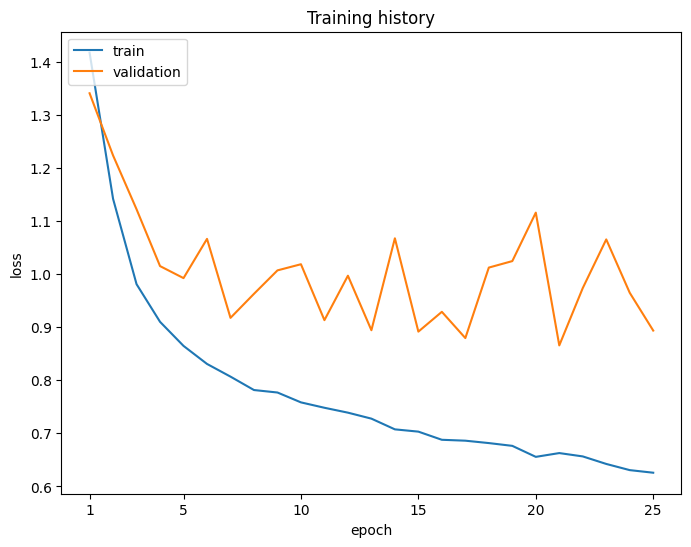

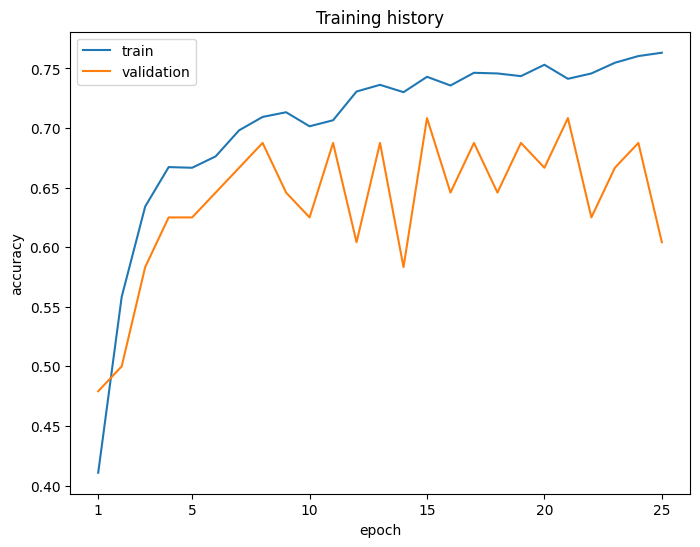

In [30]:
plot_history(history)

Load best model

In [31]:
model = keras.models.load_model("./models/dalle_prompt_rome_custom/dalle_prompt_rome_custom_16-0.7500.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

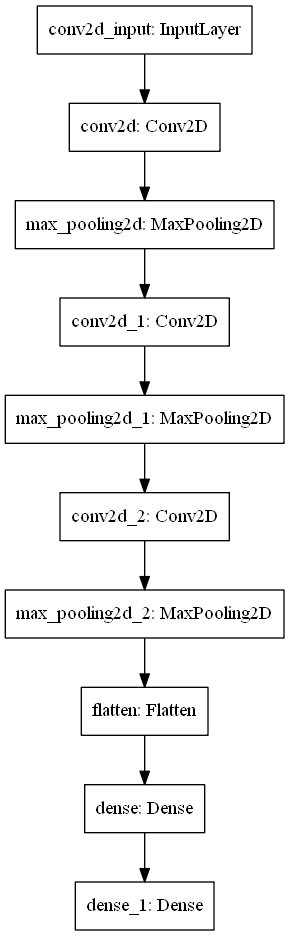

In [32]:
keras.utils.plot_model(model)

In [33]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[1 2 1 3 3]
 [1 2 1 4 2]
 [4 1 0 2 3]
 [3 2 1 3 1]
 [1 2 0 4 3]]


Class foggy:
    Sensitivity (TPR):  10.000% (1 of 10)
    Specificity (TNR):  77.500% (31 of 40)
    Precision:          10.000% (1 of 10)
    Neg. pred. value:   77.500% (31 of 40)
Class cloudy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  82.500% (33 of 40)
    Precision:          22.222% (2 of 9)
    Neg. pred. value:   80.488% (33 of 41)
Class sunny:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  92.500% (37 of 40)
    Precision:           0.000% (0 of 3)
    Neg. pred. value:   78.723% (37 of 47)
Class snowy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  67.500% (27 of 40)
    Precision:          18.750% (3 of 16)
    Neg. pred. value:   79.412% (27 of 34)
Class rainy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  77.500% (31 of 40)
    Precision:          25.000% (3 of 12)
    Neg. pred. value:   81.579% (31 of 38)

Overall accuracy:

array([[1, 2, 1, 3, 3],
       [1, 2, 1, 4, 2],
       [4, 1, 0, 2, 3],
       [3, 2, 1, 3, 1],
       [1, 2, 0, 4, 3]], dtype=int64)